In [1]:
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA as ARIMA_new
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']    # 显示中文
plt.rcParams['axes.unicode_minus'] = False      # 解决负号显示问题


data_path = "数据.xlsx"   # 修改成你自己的路径
df = pd.read_excel(data_path)

year = df['Unnamed: 0'].str.replace('年', '', regex=False).astype(int)

quarter_map = {'一季度': 1, '二季度': 2, '三季度': 3, '四季度': 4}
quarter = df['Unnamed: 1'].map(quarter_map).astype(int)

# 构造季度型时间索引
period_index = pd.PeriodIndex(
    year.astype(str) + 'Q' + quarter.astype(str),
    freq='Q'
)
df['date'] = period_index.to_timestamp()   # 转成时间戳，便于绘图等

df = df.set_index('date').sort_index()

# 选取需要做主成分分析的经济指标列（你可以按需要增删）
feature_cols = [
    'GDP（亿元）',
    '第二产业GDP（亿元）',
    '第三产业GDP（亿元）',
    '固定资产投资（亿元）',
    '社会消费品零售总额（亿元）',
    '外贸进出口总额（亿美元）',
    '农村人均可支配收入（元）',
    '城镇人均可支配收入（元）',
    '公共财政预算支出（亿元）',
    '公共财政预算收入(亿元)',
    'CPI(%)',
    'PPI(%)',
    '失业率'
]

data = df[feature_cols].copy()
data_used = data.interpolate().ffill().bfill()
print("时间序列预处理后数据维度:", data_used.shape)


时间序列预处理后数据维度: (45, 13)



主成分特征值及方差贡献率：
     Eigenvalue  Proportion  Cumulative
PC1    7.539981    0.698866    0.698866
PC2    1.930356    0.178921    0.877787
PC3    1.318536    0.122213    1.000000

前 3 个主成分的载荷矩阵：
                    PC1       PC2       PC3
GDP（亿元）       -0.343668 -0.172961 -0.134915
第二产业GDP（亿元）   -0.335616 -0.178453 -0.205112
第三产业GDP（亿元）   -0.343986 -0.138063 -0.067232
固定资产投资（亿元）    -0.312258  0.039894  0.226379
社会消费品零售总额（亿元） -0.319692 -0.281892  0.044335
外贸进出口总额（亿美元）  -0.329033  0.040538 -0.284624
农村人均可支配收入（元）  -0.256672  0.382361  0.335218
城镇人均可支配收入（元）  -0.274856  0.330030  0.291603
公共财政预算支出（亿元）  -0.333256 -0.010344 -0.087958
公共财政预算收入(亿元)  -0.080733  0.661896  0.017152
CPI(%)        -0.015414  0.019657  0.020796
PPI(%)        -0.207690  0.242518 -0.515526
失业率            0.201446  0.289733 -0.573890


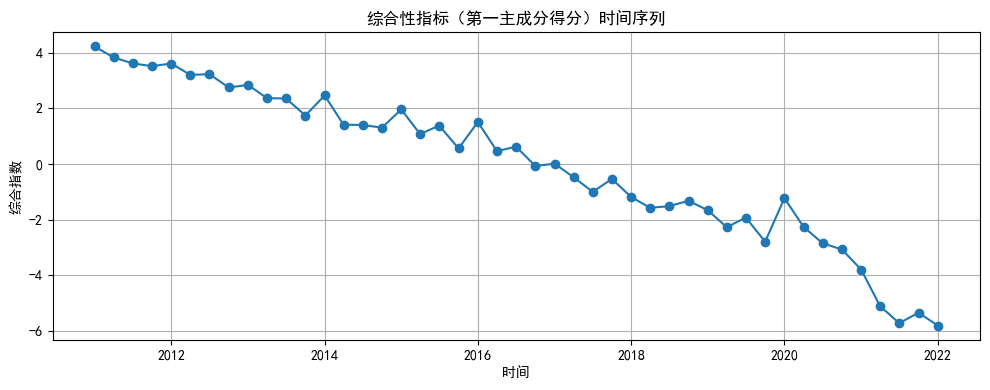

In [2]:
def PCA(x,components=None):
    x = np.asarray(x, dtype=float)
    r, c = x.shape

    if components is None:
        components = c
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0, ddof=1)
    x_std = (x - mean) / std
    cov_matrix = np.cov(x_std.T)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    idx = np.argsort(-eigenvalues)
    eigenvalues_sorted = eigenvalues[idx]
    eigenvectors_sorted = eigenvectors[:, idx]

    eigenvalues_sel = eigenvalues_sorted[:components]
    eigenvectors_sel = eigenvectors_sorted[:, :components]  # shape = (变量数, components)

    scores = x_std @ eigenvectors_sel  # shape = (样本数, components)

    return eigenvalues_sel, eigenvectors_sel, scores, mean, std


X = data_used.values

eigenvalues, eigenvectors, scores, mean_vec, std_vec = PCA(X, components=3)

ev_df = pd.DataFrame(
    {'Eigenvalue': eigenvalues},
    index=[f'PC{i}' for i in range(1, len(eigenvalues) + 1)]
)
prop = ev_df['Eigenvalue'] / ev_df['Eigenvalue'].sum()   # 方差贡献率
cum_prop = prop.cumsum()                                 # 累计贡献率
ev_df['Proportion'] = prop
ev_df['Cumulative'] = cum_prop

print("\n主成分特征值及方差贡献率：")
print(ev_df)

loadings = pd.DataFrame(
    eigenvectors,                 # 注意：eigenvectors 是 (变量数 × 总主成分数)
    index=feature_cols,
    columns=[f'PC{i}' for i in range(1, eigenvectors.shape[1] + 1)]
)
print("\n前 3 个主成分的载荷矩阵：")
print(loadings.iloc[:, :3])

composite_index = pd.Series(
    scores[:, 0],                 # 第一主成分
    index=data_used.index,
    name='综合指数(PC1)'
)

# 画一下综合指数随时间变化
plt.figure(figsize=(10, 4))
plt.plot(composite_index.index, composite_index.values, marker='o')
plt.title('综合性指标（第一主成分得分）时间序列')
plt.xlabel('时间')
plt.ylabel('综合指数')
plt.grid(True)
plt.tight_layout()
plt.show()


ADF 单位根检验结果：
ADF 统计量: 1.0987
p 值: 0.9952
临界值：
  1%: -3.5925
  5%: -2.9315
  10%: -2.6041

ARIMA 模型摘要：
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   45
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -42.834
Date:                Thu, 20 Nov 2025   AIC                             93.668
Time:                        22:23:31   BIC                            100.895
Sample:                             0   HQIC                            96.362
                                 - 45                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7026      4.722     -0.149      0.882      -9.957       8.552
ar.L1          0.9944      0

D:\Application\anaconda3\envs\pytorch_0\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\10514\AppData\Local\Temp\ipykernel_6836\1339573677.py:27: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_index = pd.date_range(last_idx, periods=steps+1, freq='Q')[1:]


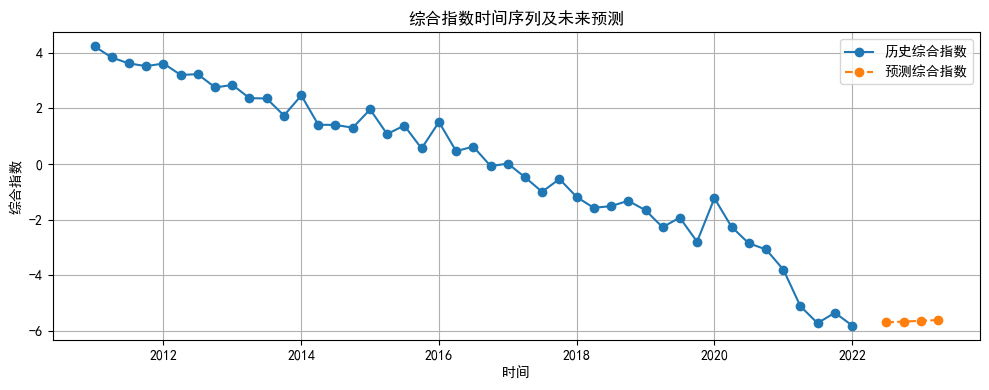

In [3]:
adf_stat, p_value, usedlag, nobs, crit_vals, icbest = adfuller(composite_index)
print("\nADF 单位根检验结果：")
print(f"ADF 统计量: {adf_stat:.4f}")
print(f"p 值: {p_value:.4f}")
print("临界值：")
for k, v in crit_vals.items():
    print(f"  {k}: {v:.4f}")

series_for_model = composite_index.copy()
d_order = 0
# if p_value >= 0.05:
#     print("\n综合指数不平稳，对其做一阶差分后再建模。")
#     series_for_model = composite_index.diff().dropna()
#     d_order = 1
y = np.asarray(series_for_model.values, dtype='float64')
model = ARIMA_new(y, order=(1, d_order, 1))
model_fit = model.fit()
print("\nARIMA 模型摘要：")
print(model_fit.summary())

steps = 4
forecast_vals = model_fit.forecast(steps=steps)

# 给预测结果造一个“未来季度”的时间索引，再包回 Series
last_idx = series_for_model.index[-1]
# 以“季度末”为频率向后推 4 期，你也可以用 'Q' 或 'QS' 看自己需要
future_index = pd.date_range(last_idx, periods=steps+1, freq='Q')[1:]

forecast = pd.Series(forecast_vals, index=future_index, name='预测综合指数')

print("\n未来 4 期预测值：")
print(forecast)

plt.figure(figsize=(10, 4))
plt.plot(composite_index.index, composite_index.values,
         label='历史综合指数', marker='o')
plt.plot(forecast.index, forecast.values,
         label='预测综合指数', marker='o', linestyle='--')
plt.title('综合指数时间序列及未来预测')
plt.xlabel('时间')
plt.ylabel('综合指数')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()